In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import logomaker

import glob
import re
from sklearn.decomposition import PCA

%matplotlib inline
plt.ion()

In [3]:
# Load data
data_df_ER = pd.read_csv('data_ER.txt', delimiter='\t', index_col=0)
data_df_IM = pd.read_csv('data_IM.txt', delimiter='\t', index_col=0)
data_df_IM_raw = pd.read_csv('data_IM_raw.txt', delimiter='\t', index_col=0)
data_df_ER.head()

,ars,mut,strain,exp,00.A,00.C,00.G,00.T,01.A,01.C,...,47.G,47.T,48.A,48.C,48.G,48.T,49.A,49.C,49.G,49.T
name,,,,,,,,,,,,,,,,,,,,,
exp6_ars317_m3,ars317,F485I,m3,exp6,0.000608,-0.000135,-0.005687,0.005214,-0.006689,0.016712,...,-0.051668,0.065589,-0.017101,0.022190,-0.025095,0.020006,0.013657,-0.008861,0.011089,-0.015885
exp7_ars317_m3,ars317,F485I,m3,exp7,-0.012277,-0.006304,-0.008667,0.027248,-0.011322,-0.002515,...,-0.051958,0.049696,0.005546,0.020526,-0.033687,0.007616,0.032752,-0.015023,0.000840,-0.018569
exp6_ars317_m21,ars317,FY-AA,m21,exp6,0.006325,-0.000532,-0.017159,0.011367,-0.005034,0.009384,...,-0.097784,0.114822,-0.031425,0.045118,-0.030902,0.017209,0.016354,-0.001037,0.016828,-0.032146
exp7_ars317_m21,ars317,FY-AA,m21,exp7,0.003310,-0.002844,-0.013020,0.012554,-0.020349,0.010438,...,-0.090126,0.106316,-0.022390,0.039244,-0.027509,0.010655,0.019303,-0.012508,0.010904,-0.017698
exp5_ars317_m22,ars317,FY-IQ,m22,exp5,-0.003885,-0.006201,-0.002286,0.012372,-0.031658,0.021184,...,-0.081712,0.071076,-0.016518,0.047526,-0.005821,-0.025187,0.008624,-0.019365,0.042686,-0.031946


['10.A', '10.C', '10.G', '10.T', '11.A', '11.C', '11.G', '11.T', '12.A', '12.C', '12.G', '12.T']
['37.A', '37.C', '37.G', '37.T', '38.A', '38.C', '38.G', '38.T', '39.A', '39.C', '39.G', '39.T']


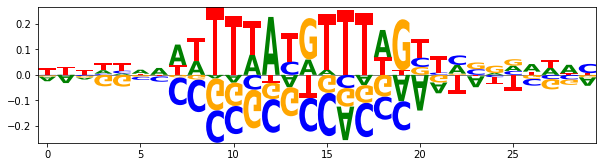

In [5]:
# Show logos
def extract_matrix(df, index, min_pos=None, max_pos=None):
    """
    Extracts a matrix from a dataframe
    """
    
    # Get list of all columns
    L = int(len([c for c in df.columns if '.' in c])/4)
    
    # Set min_pos
    if min_pos is None:
        min_pos = 0
        
    # Set max_pos
    if max_pos is None:
        max_pos = L
    
    # Create list of columns to extract
    cols = ['%02d.%s'%(i,c) for i in range(min_pos,max_pos) for c in 'ACGT']
    print(cols[:12])
    print(cols[-12:])
    
    vec = df.loc[index,cols].values
    mat_arr = vec.reshape(-1,4)
    mat_df = pd.DataFrame(data=mat_arr, columns=list('ACGT'), dtype=float)
    return mat_df
mat_df = extract_matrix(df=data_df_IM, index='exp4_ars416_wt', min_pos=10, max_pos=40)
logo = logomaker.Logo(df=mat_df)

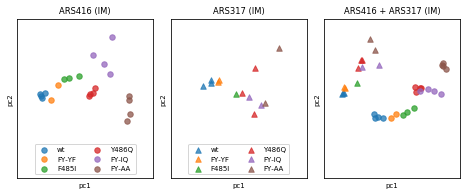

In [21]:
# Create figure
plt.rcParams['font.size']=7
fig, axs = plt.subplots(1,3,figsize=[6.5,3.5])

strain_list = [
 'wt',
 'FY-YF',
 'F485I',
 'Y486Q',
 'FY-IQ',
 'FY-AA']

data_df = data_df_IM.copy()
data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]

# ars416 indices
indices1 = data_df['ars'].str.match('ars416')
indices1 &= data_df['mut'].isin(strain_list)
indices1 &= data_df['exp'].isin(['exp4','exp7','exp9'])
#indices &= ~((data_df['exp']=='exp7') & data_df['mut'].str.match('FY-IQ'))  # This sample looks ok

# ars317 indices
indices2 = data_df['ars'].str.match('ars317')
indices2 &= data_df['mut'].isin(strain_list)
indices2 &= data_df['exp'].isin(['exp5','exp6','exp7'])
indices2 &= ~((data_df['exp']=='exp5') & data_df['mut'].str.match('FY-IQ')) # This sample is bad

for panel_num, ars in enumerate(['ars416','ars317','both']):
    # Set panel number
    ax = axs[panel_num]
    
    # Restrict to the strains we want
    if ars=='ars416':
        indices = indices1
        title = 'ARS416 (IM)'
        
    elif ars=='ars317':
        indices = indices2
        title = 'ARS317 (IM)'
        
    elif ars=='both':
        indices = indices1 | indices2
        title = 'ARS416 + ARS317 (IM)'

    else:
        assert False, f'improper ars: {ars}'
        
    tmp_df = data_df[indices].copy()
        
    # Do PCA
    pca = PCA(n_components=2)
    X = tmp_df.loc[:,data_cols]
    pcs = pca.fit_transform(X)
    pca_cols = ['pc1','pc2']
    pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
    pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)
    
    # Get default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Cycle through strains
    for i, strain in enumerate(strain_list):
        # Restrict df to chosen strain
        indices = (pca_df['mut']==strain) 
        tmp2_df = pca_df.loc[indices,:]
        
        xs = tmp2_df['pc1']
        ys = tmp2_df['pc2']
        ix = tmp2_df['ars']=='ars416'

        # Plot 416 points
        if sum(ix) > 0:
            ax.scatter(x=xs[ix],y=ys[ix], 
                       label=strain,
                       color=colors[i],
                       marker='o', s=30, alpha=.75)

        # Plot 317 points
        if sum(~ix) > 0:
            ax.scatter(x=xs[~ix],y=ys[~ix], 
                       label=strain,
                       color=colors[i],
                       marker='^', s=30, alpha=.75)
        
    # Set lims
    xs = pca_df['pc1'].values
    ys = pca_df['pc2'].values
    rmax = max(np.sqrt(xs**2+ys**2))
    lims = np.array([-rmax, rmax])
    ax.set_xlim(1.2*lims)
    ax.set_ylim(1.4*lims-.2*rmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
        
    # Style plot
    if ars!='both':
        ax.legend(loc='lower center', ncol=2)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('pca_IM.pdf')

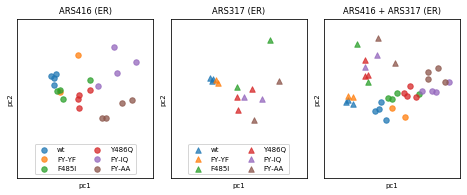

In [22]:
# Create figure for ER
plt.rcParams['font.size']=7
fig, axs = plt.subplots(1,3,figsize=[6.5,3.5])

data_df = data_df_ER.copy()

strain_list = [
 'wt',
 'FY-YF',
 'F485I',
 'Y486Q',
 'FY-IQ',
 'FY-AA']

data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]

# ER indices
indices1 = data_df['ars'].str.match('ars416')
indices1 &= data_df['mut'].isin(strain_list)
indices1 &= data_df['exp'].isin(['exp4','exp7','exp9'])
#indices &= ~((data_df['exp']=='exp7') & data_df['mut'].str.match('FY-IQ'))  # This sample looks ok

# ars317 indices
indices2 = data_df['ars'].str.match('ars317')
indices2 &= data_df['mut'].isin(strain_list)
indices2 &= data_df['exp'].isin(['exp5','exp6','exp7'])
indices2 &= ~((data_df['exp']=='exp5') & data_df['mut'].str.match('FY-IQ')) # This sample is bad

for panel_num, ars in enumerate(['ars416','ars317','both']):
    # Set panel number
    ax = axs[panel_num]
    
    # Restrict to the strains we want
    if ars=='ars416':
        indices = indices1
        title = 'ARS416 (ER)'
        
    elif ars=='ars317':
        indices = indices2
        title = 'ARS317 (ER)'
        
    elif ars=='both':
        indices = indices1 | indices2
        title = 'ARS416 + ARS317 (ER)'

    else:
        assert False, f'improper ars: {ars}'
        
    tmp_df = data_df[indices].copy()
        
    # Do PCA
    pca = PCA(n_components=2)
    X = tmp_df.loc[:,data_cols]
    pcs = pca.fit_transform(X)
    pca_cols = ['pc1','pc2']
    pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
    pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)
    
    # Get default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Cycle through strains
    for i, strain in enumerate(strain_list):
        # Restrict df to chosen strain
        indices = (pca_df['mut']==strain) 
        tmp2_df = pca_df.loc[indices,:]
        
        xs = tmp2_df['pc1']
        ys = tmp2_df['pc2']
        ix = tmp2_df['ars']=='ars416'

        # Plot 416 points
        if sum(ix) > 0:
            ax.scatter(x=xs[ix],y=ys[ix], 
                       label=strain,
                       color=colors[i],
                       marker='o', s=30, alpha=.75)

        # Plot 317 points
        if sum(~ix) > 0:
            ax.scatter(x=xs[~ix],y=ys[~ix], 
                       label=strain,
                       color=colors[i],
                       marker='^', s=30, alpha=.75)
        
    # Set lims
    xs = pca_df['pc1'].values
    ys = pca_df['pc2'].values
    rmax = max(np.sqrt(xs**2+ys**2))
    lims = np.array([-rmax, rmax])
    ax.set_xlim(1.2*lims)
    ax.set_ylim(1.4*lims-.2*rmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
        
    # Style plot
    if ars!='both':
        ax.legend(loc='lower center', ncol=2)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('pca_ER.pdf')

In [24]:
# Create plot contrasting IM vs. ER
data_df_IM = data_df_IM.copy()
data_df_IM['lm'] = 'IM'
data_df_ER = data_df_ER.copy()
data_df_ER['lm'] = 'ER'
data_df = pd.concat([data_df_IM, data_df_ER])

data_df.tail()

,ars,mut,strain,exp,00.A,00.C,00.G,00.T,01.A,01.C,...,47.T,48.A,48.C,48.G,48.T,49.A,49.C,49.G,49.T,lm
name,,,,,,,,,,,,,,,,,,,,,
exp4_ars416_wt,ars416,wt,wt,exp4,0.019802,-0.012298,-0.021891,0.014387,0.010539,0.001367,...,0.068199,-0.046601,0.035045,-0.004394,0.015951,0.002738,-0.011640,0.029193,-0.020291,ER
exp7_ars416_wt,ars416,wt,wt,exp7,0.007595,-0.012474,-0.013184,0.018063,0.019382,-0.003793,...,0.073216,-0.008490,0.020053,-0.013200,0.001637,0.009444,-0.008052,0.020187,-0.021579,ER
exp8_ars416_wt,ars416,wt,wt,exp8,0.007080,-0.014493,-0.023117,0.030530,0.023362,-0.017377,...,0.086351,0.000223,0.007176,-0.026772,0.019374,0.026725,-0.013207,0.021890,-0.035408,ER
exp9_ars416_wtc1,ars416,wt,wtc1,exp9,0.008152,-0.003662,-0.009378,0.004889,0.019374,-0.004647,...,0.075190,0.000316,0.006363,-0.013708,0.007029,0.020020,-0.005385,0.010710,-0.025346,ER
exp9_ars416_wtc6,ars416,wt,wtc6,exp9,0.000431,-0.011029,-0.013799,0.024397,0.017172,-0.006898,...,0.074860,-0.012950,0.015406,-0.008831,0.006375,0.016932,-0.004225,0.014264,-0.026971,ER


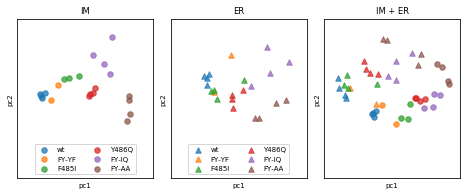

In [26]:
# Create figure for ER
plt.rcParams['font.size']=7
fig, axs = plt.subplots(1,3,figsize=[6.5,3.5])

strain_list = [
 'wt',
 'FY-YF',
 'F485I',
 'Y486Q',
 'FY-IQ',
 'FY-AA']

data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]

# ER+IM indices
indices12 = data_df['ars'].str.match('ars416')
indices12 &= data_df['mut'].isin(strain_list)
indices12 &= data_df['exp'].isin(['exp4','exp7','exp9'])
indices1 = indices12 & data_df['lm'].str.match('IM')
indices2 = indices12 & data_df['lm'].str.match('ER')

for panel_num, lm in enumerate(['IM','ER','both']):
    # Set panel number
    ax = axs[panel_num]
    
    # Restrict to the strains we want
    if lm=='IM':
        indices = indices1
        title = 'IM'
        
    elif lm=='ER':
        indices = indices2
        title = 'ER'
        
    elif lm=='both':
        indices = indices1 | indices2
        title = 'IM + ER'

    else:
        assert False, f'improper lm: {lm}'
        
    tmp_df = data_df[indices].copy()
        
    # Do PCA
    pca = PCA(n_components=2)
    X = tmp_df.loc[:,data_cols]
    pcs = pca.fit_transform(X)
    pca_cols = ['pc1','pc2']
    pca_df = pd.DataFrame(data=pcs, columns=pca_cols, index=tmp_df.index)
    pca_df = pd.concat([tmp_df[info_cols], pca_df], axis=1)
    
    # Get default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Cycle through strains
    for i, strain in enumerate(strain_list):
        # Restrict df to chosen strain
        indices = (pca_df['mut']==strain) 
        tmp2_df = pca_df.loc[indices,:]
        
        xs = tmp2_df['pc1']
        ys = tmp2_df['pc2']
        ix = tmp2_df['lm']=='IM'

        # Plot 416 points
        if sum(ix) > 0:
            ax.scatter(x=xs[ix],y=ys[ix], 
                       label=strain,
                       color=colors[i],
                       marker='o', s=30, alpha=.75)

        # Plot 317 points
        if sum(~ix) > 0:
            ax.scatter(x=xs[~ix],y=ys[~ix], 
                       label=strain,
                       color=colors[i],
                       marker='^', s=30, alpha=.75)
        
    # Set lims
    xs = pca_df['pc1'].values
    ys = pca_df['pc2'].values
    rmax = max(np.sqrt(xs**2+ys**2))
    lims = np.array([-rmax, rmax])
    ax.set_xlim(1.2*lims)
    ax.set_ylim(1.4*lims-.2*rmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
        
    # Style plot
    if lm!='both':
        ax.legend(loc='lower center', ncol=2)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('pca_ERvIM.pdf')

In [18]:
indices1 = indices12 & data_df['lm'].str.match('IM')
indices2 = indices12 & data_df['lm'].str.match('ER')
indices2.sum()

22